In [13]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem, Descriptors, QED
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv

RDLogger.DisableLog("rdApp.*")

# Must match training notebook
NUM_ATOMS = 9
ATOM_DIM = 4 + 1
BOND_DIM = 4 + 1
LATENT_DIM = 64

gen_weights_path = "./my_model/generator.weights.h5"


In [14]:
# Mapping atom symbols to integers and vice versa
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

In [15]:
# Mapping bond types to integers and vice versa
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

In [16]:
# Function to convert a SMILES string to a graph representation
def smiles_to_graph(smiles):
    # Converting SMILES to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initializing adjacency and features matrices
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # Processing atoms and bonds in the molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Handling disconnected atoms and empty features
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


In [17]:
# Function to convert a graph representation to an RDKit molecule object
def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol() # Creates an rdkit editable molecule (read-write Mol)

    # Selecting atoms and bonds for the final molecule
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)  # This is true for non-PAD (real atoms) and False for PAD atoms 
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)    # Check if each atom participates in any real bond
    )[0] 
    features = features[keep_idx] # has shape (N_kept, ATOM_DIM)
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx] # has shape (BOND_DIM, N_kept, N_kept)

    # Adding atoms to the molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])  #convert type index into chemical element
        _ = molecule.AddAtom(atom)

    # Adding bonds to the molecule
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1) # np.triu ensures you count each edge once (only the upper triangle, i ≤ j).
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j): # atoms_i - row atom index, atoms_j- column atom index.
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:   # Skip self-loops and no-bond channel
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)  # RDKit bond type and add

    # Checking and sanitizing the molecule
    flag = Chem.SanitizeMol(molecule, catchErrors=True) # checks and fixes any wrong valence counts, aromaticity flags, charges, implicit and explicit hydrogens.
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:   # None if invalid, otherwise the final Mol
        return None

    return molecule

In [18]:
def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    adj_units = int(np.prod(adjacency_shape))
    feat_units = int(np.prod(feature_shape))

    x_adjacency = keras.layers.Dense(adj_units)(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    x_adjacency = keras.layers.Lambda(
        lambda a: (a + tf.transpose(a, (0, 1, 3, 2))) / 2.0
    )(x_adjacency)
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    x_features = keras.layers.Dense(feat_units)(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


In [19]:
## Function to sample molecules from the generated model

def sample_molecules(generator, batch_size=48):    # Generating 48 molecules in one batch
    z = tf.random.normal((batch_size, LATENT_DIM))  # Generate random noise with shape of batch size and latent dim.
    adj_logits, feat_logits = generator(z, training=False)  # Generate a graph representing a molecule

    adjacency = tf.argmax(adj_logits, axis=1)  # (B, N, N)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1) 
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1])) # To ensure there are no self connections in the generated molecules

    features = tf.argmax(feat_logits, axis=2)  # (B, N)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

    mols = []
    for i in range(batch_size):
        graph = [adjacency[i].numpy(), features[i].numpy()]
        mol = graph_to_molecule(graph)
        if mol is not None:
            mols.append(mol)
    return mols


# Rebuild generator architecture and load saved weights
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

generator.load_weights(gen_weights_path)




Saved 30 generated SMILES to ./my_model/generated_smiles.csv


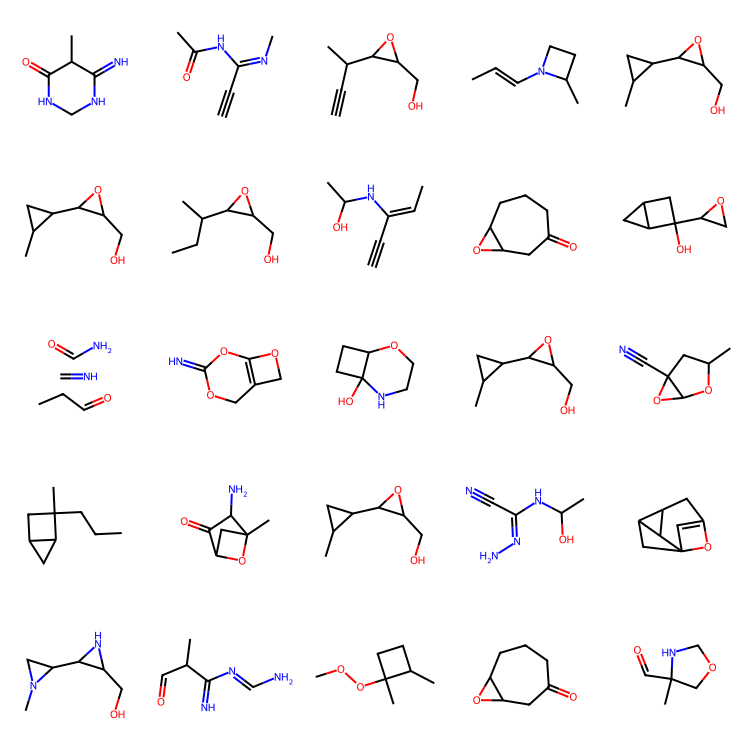

In [20]:
# Generate molecules
molecules = sample_molecules(generator, batch_size=48)

# Save generated SMILES
output_smiles_path = "./my_model/generated_smiles.csv"
smiles_list = [Chem.MolToSmiles(m) for m in molecules]

with open(output_smiles_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["smiles"])
    for s in smiles_list:
        writer.writerow([s])

print(f"Saved {len(smiles_list)} generated SMILES to {output_smiles_path}")

# Display a grid of molecules
img = MolsToGridImage(
    molecules[:25],
    molsPerRow=5,
    subImgSize=(150, 150)
)
img